## Introduction

Powerlifting is a strength sport that consists of three attempts at maximal weight on three lifts: squat, bench press, and deadlift. As in the sport of Olympic weightlifting, it involves the athlete attempting a maximal weight single lift of a barbell loaded with weight plates. Powerlifting evolved from a sport known as "odd lifts", which followed the same three-attempt format but used a wider variety of events, akin to strongman competition. Eventually odd lifts became standardized to the current three.

In competition, lifts may be performed equipped or un-equipped (typically referred to as 'raw' lifting or 'classic' in the IPF specifically). Equipment in this context refers to a supportive bench shirt or squat/deadlift suit or briefs. In some federations, knee wraps are permitted in the equipped but not un-equipped division; in others, they may be used in both equipped and un-equipped lifting. Weight belts, knee sleeves, wrist wraps and special footwear may also be used, but are not considered when distinguishing equipped from un-equipped lifting.

Competitions take place across the world. Powerlifting has been a Paralympic sport (bench press only) since 1984 and, under the IPF, is also a World Games sport. Local, national and international competitions have also been sanctioned by other federations operating independently of the IPF.

## Inspiration

I'd like to answer the following questions.
* How has the sport progressed over the years?
* How much of a difference does being subjected to drug testing make?
* How much does age and gender effect weight lifted?

Source: [Wikipedia](https://en.wikipedia.org/wiki/Powerlifting)

Acknowledgement: [OpenPowerlifting](https://www.openpowerlifting.org/) for providing a snapshot of their database.

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.max_columns', 500)

## 2. Reading/Preparing the Data

We want our data to fit the following criteria
* Age was included
* Bodyweight was included
* Whether or not was tested is included
* Didn't bomb
* Wilks was included
* Competed raw
* Competed in full power meet (SBD)

In [2]:
pl = pd.read_csv("openpowerlifting.csv")
print(pl.shape)
pl.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(911485, 36)


,Name,Sex,Event,Equipment,Age,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Tested,AgeClass,Country,Glossbrenner,Federation,Date,MeetCountry,MeetState,MeetName
0,Angie Belk Terry,F,SBD,Wraps,47.0,Mst 45-49,59.60,60,38.56,47.63,-54.43,NaN,47.63,15.88,20.41,-24.95,NaN,20.41,61.23,70.31,-77.11,NaN,70.31,138.35,1,155.05,167.76,No,45-49,NaN,137.00,365Strong,2016-10-29,USA,NC,Junior & Senior National Powerlifting Champion...
1,Dawn Bogart,F,SBD,Single-ply,42.0,Mst 40-44,58.51,60,120.20,136.08,142.88,NaN,142.88,88.45,95.25,-97.52,NaN,95.25,136.08,149.69,163.29,NaN,163.29,401.42,1,456.38,465.50,No,40-44,NaN,403.37,365Strong,2016-10-29,USA,NC,Junior & Senior National Powerlifting Champion...
2,Dawn Bogart,F,SBD,Single-ply,42.0,Open Senior,58.51,60,120.20,136.08,142.88,NaN,142.88,88.45,95.25,-97.52,NaN,95.25,136.08,149.69,163.29,NaN,163.29,401.42,1,456.38,465.50,No,40-44,NaN,403.37,365Strong,2016-10-29,USA,NC,Junior & Senior National Powerlifting Champion...
3,Dawn Bogart,F,B,Raw,42.0,Open Senior,58.51,60,NaN,NaN,NaN,NaN,NaN,88.45,95.25,-97.52,NaN,95.25,NaN,NaN,NaN,NaN,NaN,95.25,1,108.29,110.46,No,40-44,NaN,95.71,365Strong,2016-10-29,USA,NC,Junior & Senior National Powerlifting Champion...
4,Destiny Dula,F,BD,Raw,18.0,Teen 18-19,63.68,67.5,NaN,NaN,NaN,NaN,NaN,29.48,31.75,-34.02,NaN,31.75,90.72,-97.52,NaN,NaN,90.72,122.47,1,130.47,138.29,No,18-19,NaN,115.19,365Strong,2016-10-29,USA,NC,Junior & Senior National Powerlifting Champion...


Now let's check how much of our data is missing.

In [3]:
pl.isna().mean().round(4) * 100

Name                0.00
Sex                 0.00
Event               0.00
Equipment           0.00
Age                34.52
Division            0.93
BodyweightKg        0.82
WeightClassKg       0.67
Squat1Kg           68.41
Squat2Kg           68.82
Squat3Kg           69.71
Squat4Kg           99.65
Best3SquatKg       32.90
Bench1Kg           53.92
Bench2Kg           54.51
Bench3Kg           55.88
Bench4Kg           99.15
Best3BenchKg        9.78
Deadlift1Kg        66.13
Deadlift2Kg        66.84
Deadlift3Kg        68.34
Deadlift4Kg        99.13
Best3DeadliftKg    26.66
TotalKg             6.09
Place               0.00
Wilks               6.71
McCulloch           6.71
Tested              0.00
AgeClass           42.14
Country            64.84
Glossbrenner        6.71
Federation          0.00
Date                0.00
MeetCountry         0.00
MeetState          44.64
MeetName            0.00
dtype: float64

We can see that we have quite a few irrelevant variables as well variables where a large proportion is missing, we'll discard these variables. However keep the Best3LiftKg since we will definetely need this variable, as well as filter for only raw full power lifters.

In [4]:
pl = pl.drop(['Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Squat4Kg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Bench4Kg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Deadlift4Kg', 'AgeClass', 'Country', 'MeetState'], axis=1)
pl = pl[pl['Event'] == 'SBD']
pl = pl[pl['Equipment'] == 'Raw']

In [5]:
pl.describe()

,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,McCulloch,Glossbrenner
count,183833.000000,241188.000000,237912.000000,237151.000000,237291.000000,232835.000000,232655.000000,232655.000000,232655.000000
mean,29.285071,83.236530,161.041372,105.620586,190.520587,458.843349,338.174810,348.998819,317.043359
std,11.617806,21.166201,59.580600,44.347138,60.067593,154.525276,66.394143,65.757361,67.021745
min,5.000000,17.690000,-407.850000,-235.000000,-347.500000,40.000000,37.290000,43.440000,35.880000
25%,21.000000,67.500000,115.000000,67.500000,140.600000,325.000000,294.690000,305.660000,271.320000
50%,26.000000,81.300000,160.000000,107.500000,192.500000,465.000000,339.700000,349.650000,318.880000
75%,34.500000,95.300000,202.500000,137.500000,235.000000,575.000000,382.760000,392.630000,363.230000
max,93.500000,258.000000,485.000000,322.500000,440.000000,1105.000000,634.840000,747.490000,587.310000


We have some negative values where it makes no sense so we'll take the absolute values assuming these are data entry errors and reformat the date

In [6]:
pl = pl.loc[pl['Best3SquatKg'] > 0]
pl = pl.loc[pl['Best3BenchKg'] > 0]
pl = pl.loc[pl['Best3DeadliftKg'] > 0]

pl['Year'] = pd.DatetimeIndex(pl['Date']).year  
pl = pl.drop(['Date'], axis=1)

print(pl.shape)
pl.isna().mean().round(4) * 100

(232943, 21)


Name                0.00
Sex                 0.00
Event               0.00
Equipment           0.00
Age                24.13
Division            0.33
BodyweightKg        0.08
WeightClassKg       0.62
Best3SquatKg        0.00
Best3BenchKg        0.00
Best3DeadliftKg     0.00
TotalKg             0.10
Place               0.00
Wilks               0.18
McCulloch           0.18
Tested              0.00
Glossbrenner        0.18
Federation          0.00
MeetCountry         0.00
MeetName            0.00
Year                0.00
dtype: float64

Since there are so little remaining missing values we'll just drop those rows. As for age I want to keep this variable so we'll replace all missing with the mean of the column.

In [7]:
pl = pl.dropna(subset = ['Division', 'BodyweightKg', 'WeightClassKg', 'TotalKg', 'Wilks', 'McCulloch', 'Glossbrenner'])
pl[['Age']] = pl[['Age']].fillna(pl['Age'].mean())

print(pl.shape)

(230358, 21)


## 3. Sport Growth Analysis

The sport is dominated by males so let's see what proportion are females and males.

In [8]:
print('Percentage of Male lifters: ', round(len(pl[pl['Sex']=='M'])/len(pl)*100),'%')
print('Percentage of Female lifters: ', round(len(pl[pl['Sex']=='F'])/len(pl)*100),'%')

Percentage of Male lifters:  66 %
Percentage of Female lifters:  34 %


Let's take a look at the growth of the sport over the years.

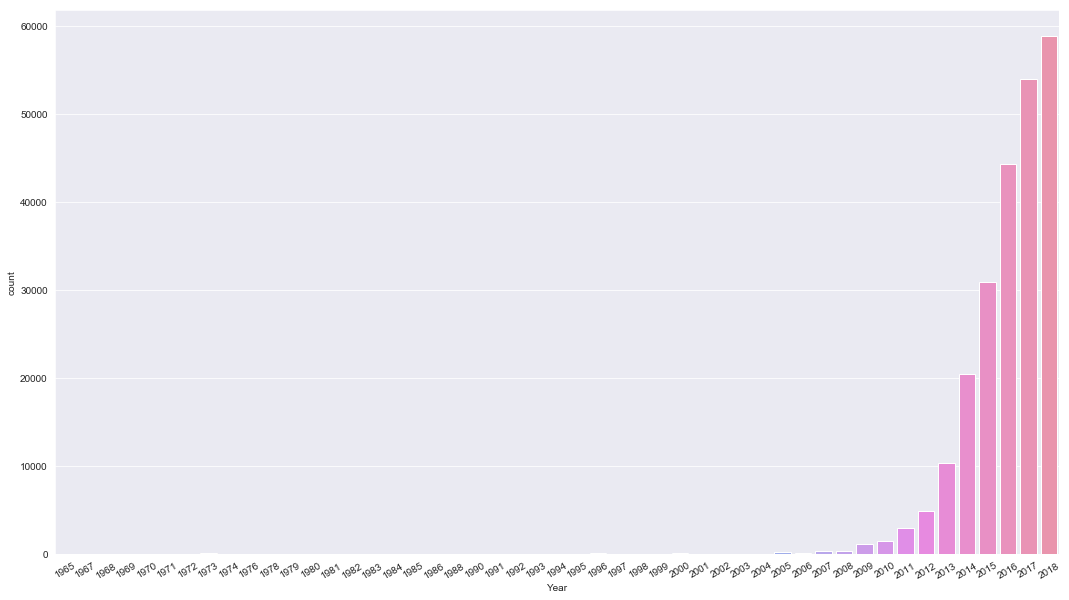

In [9]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(18,10))

t = sns.countplot(x='Year', data=pl)
t.set_xticklabels(t.get_xticklabels(), rotation=30)
plt.show()

There's an obvious spike in popularity around 2012 which continues till the current year. This was around when YouTube channels such as Omarisuf, Barbell Brigade, SuperTraining Gym, etc really picked up.

## 4. Tested vs. Non-tested

First let's see the distribution of tested and non-tested lifters, we will also group by gender as this is most likely another strong confounding variable. In this context tested means the lifter is subject to drug testing but this does not necessarily mean the lifter is tested.

Wilks is a point system based on the total weight lifted and the lifter's bodyweight (higher is better).

In [10]:
print(pl['Tested'].value_counts())

Yes    178067
No      52291
Name: Tested, dtype: int64


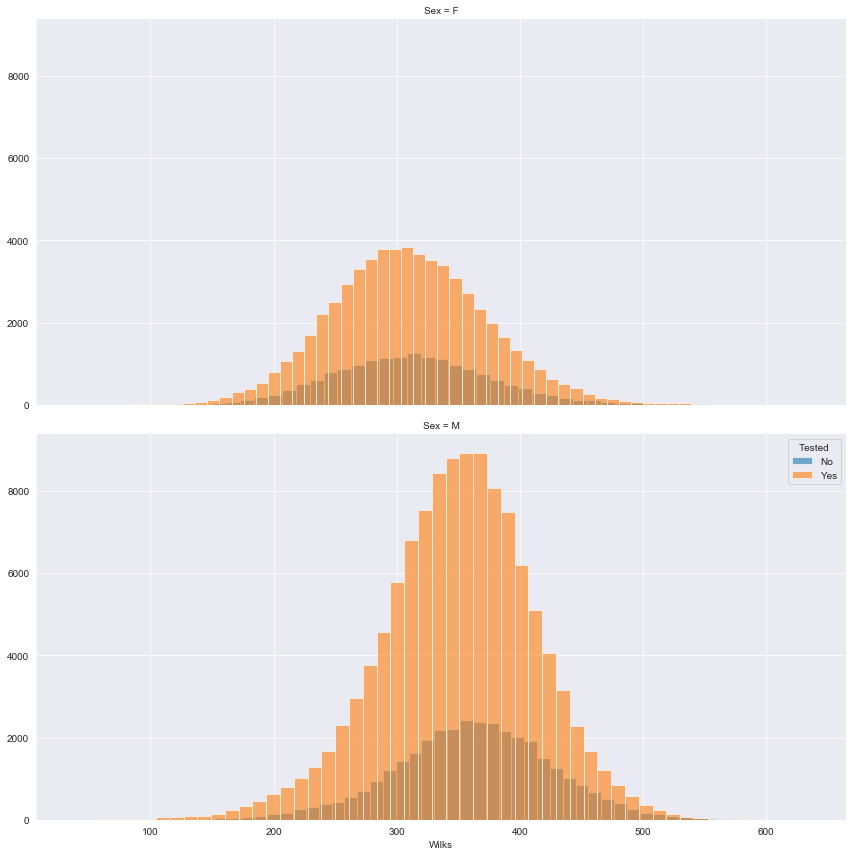

MEAN 
 Sex  Tested
F    No        312.945838
     Yes       309.482292
M    No        362.093114
     Yes       349.473347
Name: Wilks, dtype: float64


MEDIAN 
 Sex  Tested
F    No        310.83
     Yes       307.61
M    No        363.20
     Yes       351.83
Name: Wilks, dtype: float64


MAX 
 Sex  Tested
F    No        634.84
     Yes       558.86
M    No        601.50
     Yes       597.23
Name: Wilks, dtype: float64


In [11]:
grid = sns.FacetGrid(data=pl, hue='Tested', row='Sex', height=6, aspect=2)
wilks = grid.map(plt.hist, 'Wilks', bins=50, alpha=0.6)
plt.legend(title='Tested')
plt.show()

print("MEAN \n", pl.groupby(by=['Sex','Tested'])['Wilks'].mean())
print("\n\nMEDIAN \n", pl.groupby(by=['Sex', 'Tested'])['Wilks'].median())
print("\n\nMAX \n", pl.groupby(by=['Sex', 'Tested'])['Wilks'].max())

Here we can see that other from amount of people in each group the two distributions are relatively the same. The mean, median and max are slightly higher for the non-tested group which may be explained by drug use. However, my suspicion is that even though a lifter competes in a non-tested federation they are most likely not using performance enhancing drugs or are simply too novice to for it to make a significant difference. Where a more significant difference may lie is in the elite lifters nearing human capabilities. Performance enhancing drugs should raise a lifters potential, so let's compare only elite level lifters while still grouping by gender. Lets take the top lifters from each group.

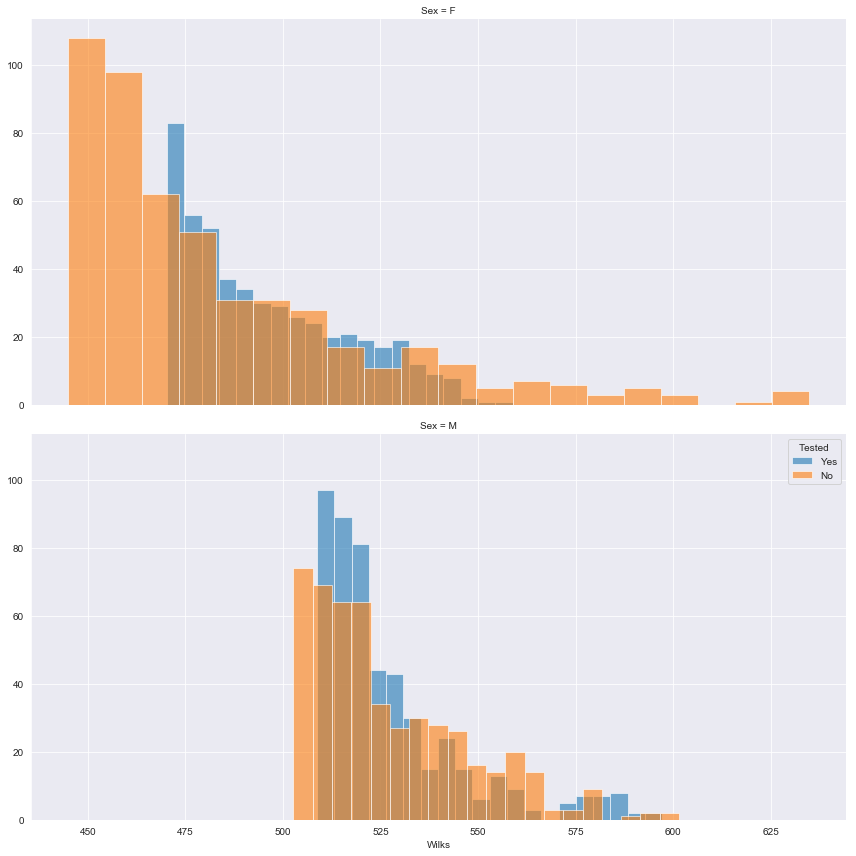

MEDIAN 
 Sex  Tested
F    No        470.840
     Yes       490.600
M    No        520.950
     Yes       521.305
Name: Wilks, dtype: float64


MEAN 
 Sex  Tested
F    No        483.17302
     Yes       495.84298
M    No        527.02630
     Yes       527.71098
Name: Wilks, dtype: float64


MAX 
 Sex  Tested
F    No        634.84
     Yes       558.86
M    No        601.50
     Yes       597.23
Name: Wilks, dtype: float64


MAX 
 Sex  Tested
F    No        1416.354828
     Yes        432.184958
M    No         405.763828
     Yes        355.306055
Name: Wilks, dtype: float64


In [12]:
# Prep groups
female_tested = pl[pl['Sex'] == 'F']
female_tested = female_tested[female_tested['Tested'] == 'Yes']
female_tested = female_tested.sort_values('Wilks', ascending=False)[0:500]

female_not_tested = pl[pl['Sex'] == 'F']
female_not_tested = female_not_tested[female_not_tested['Tested'] == 'No']
female_not_tested = female_not_tested.sort_values('Wilks', ascending=False)[0:500]

male_tested = pl[pl['Sex'] == 'M']
male_tested = male_tested[male_tested['Tested'] == 'Yes']
male_tested = male_tested.sort_values('Wilks', ascending=False)[0:500]

male_not_tested = pl[pl['Sex'] == 'M']
male_not_tested = male_not_tested[male_not_tested['Tested'] == 'No']
male_not_tested = male_not_tested.sort_values('Wilks', ascending=False)[0:500]

frames = [female_tested, female_not_tested, male_tested, male_not_tested]
result = pd.concat(frames)

grid = sns.FacetGrid(data=result, hue='Tested', row='Sex', legend_out=True, height=6, aspect=2)
top_wilks = grid.map(plt.hist, 'Wilks', bins=20, alpha=0.6)
plt.legend(title='Tested')
plt.show()

print("MEDIAN \n",result.groupby(by=['Sex','Tested'])['Wilks'].median())
print("\n\nMEAN \n",result.groupby(by=['Sex','Tested'])['Wilks'].mean())
print("\n\nMAX \n",result.groupby(by=['Sex','Tested'])['Wilks'].max())
print("\n\nMAX \n",result.groupby(by=['Sex','Tested'])['Wilks'].var())

We can see some more interesting results here. There's a large gap between female tested and untested lifters with the top untested lifter 76 points ahead of the top tested lifter. Whereas in males there is much less of a gap where the top lifter in each group are nearly identical in wilks points. Additonally, we can see that for females there are similar amounts of elite lifters in both groups however there are several untested females scoring higher than the top tested female.

Now that we've visualized the data let's try to confirm our suspicions by doing hypthesis testing. Lets start by comparing the female tested and female non-tested groups. Since our two groups are definitely not normally distributed we'll use a non-parametric test to test if the two groups come from the same population. <br> <br>
$$H_0: F_{Untested} = F_{Tested} \\
H_A: F_{Untested} \neq F_{Tested}$$

In [13]:
# Prep our two groups
female_tested = female_tested[['Wilks']]
female_not_tested = female_not_tested[['Wilks']]
male_tested = male_tested[['Wilks']]
male_not_tested = male_not_tested[['Wilks']]

print(stats.mannwhitneyu(female_not_tested, female_tested, alternative = "two-sided"))
print(stats.mannwhitneyu(male_not_tested, male_tested, alternative = "two-sided"))

MannwhitneyuResult(statistic=75790.5, pvalue=4.480133688787888e-27)
MannwhitneyuResult(statistic=117274.5, pvalue=0.09071881407268141)


For the female group the p-value is well below 0.05 so we can reject the null hypthesis that the two distributions are the same. While the male group has a p-value of 0.091 which is not enough to reject the null hypothesis at a 5% siginificance level.

## 5. How Age, Gender & Bodyweight Effect Weight Lifted

Let's first compare how age effects weight lifted while still grouping by gender.

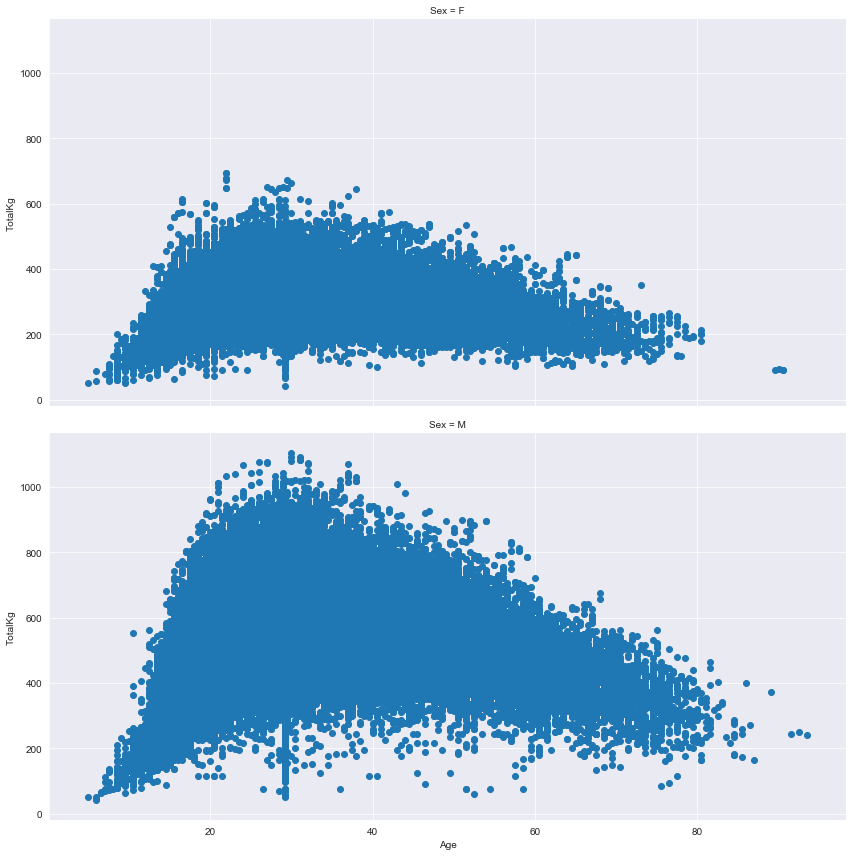

In [14]:
grid = sns.FacetGrid(data=pl, row='Sex', legend_out=True, height=6, aspect=2)
a = grid.map(plt.scatter, 'Age', 'TotalKg')
plt.show()

We can see that there is an obvious peak at about age 25 with a decline after that, which makes sense in the sport of powerlifing. Most lifters will hit a peak at around 25 while they are still young but have had enough time to train then age or life starts to hit them and their lifts decrease.

Let's now do the same plots with bodyweight.

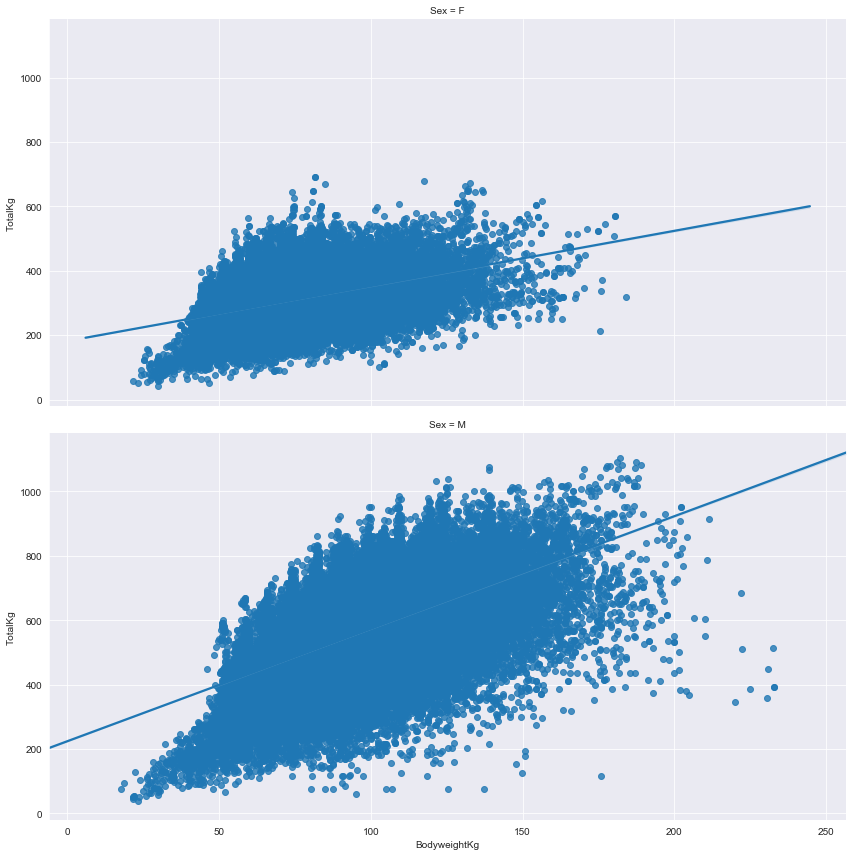

In [15]:
bw = sns.lmplot(data=pl, x='BodyweightKg', y='TotalKg', row='Sex', height=6, aspect=2)
plt.show()

Again nothing too surprising here, a clear positive correlation can be seen between bodyweight and weight lifted. However there seems to be a higher slope for males compared to females. This may be because in general males can be put on more muscle mass leading to heavier lifts.

## 6. Modeling the Data

Since wilks itself is just that formula that takes gender, bodyweight, and weight lifted let's see if we can exactly predict bodyweight using wilks, gender and weight lifted. I plan to use linear regression with a polynomial basis so let's check the assumptions first. We'll check for normality, homoscedasticity, linearity, absence of correlated errors.

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


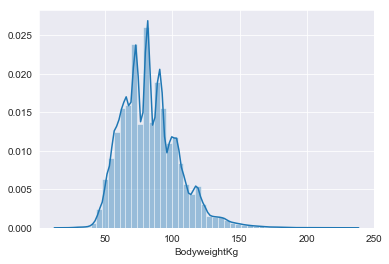

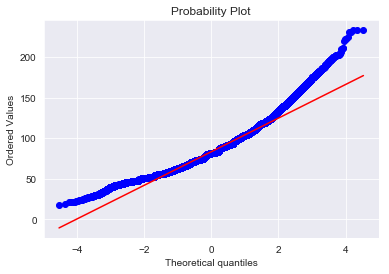

In [16]:
df = pl[['Wilks', 'Sex', 'TotalKg', 'BodyweightKg']]
df['Sex'].replace(['F','M'],[0,1],inplace=True)

# BodyweightKg
sns.distplot(df['BodyweightKg'])
plt.show()
res = stats.probplot(df['BodyweightKg'], plot=plt)

Ok, BodyweightKg is not normal. It shows right skewness and does not follow the diagonal line. But a simple data transformation can fix this, a log transformation.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


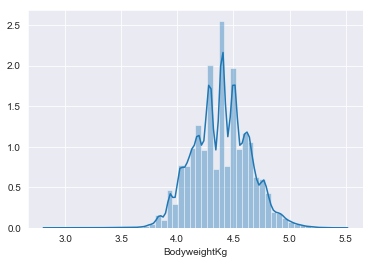

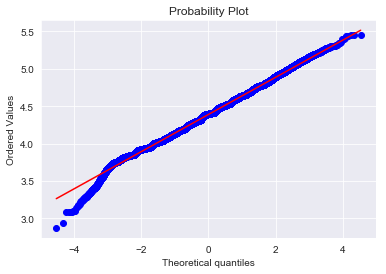

In [17]:
df['BodyweightKg'] = np.log(df['BodyweightKg'])

sns.distplot(df['BodyweightKg'])
plt.show()
res = stats.probplot(df['BodyweightKg'], plot=plt)

We only require our outcome variable to have a normal distribution so let's move onto checking for homoscedasticity.

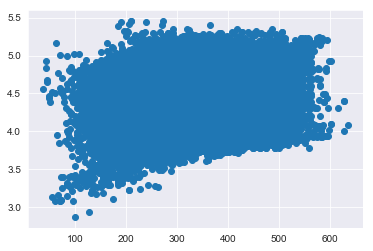

In [18]:
plt.scatter(df['Wilks'], df['BodyweightKg'])
plt.show()

The variance here looks constant so lets check the other.

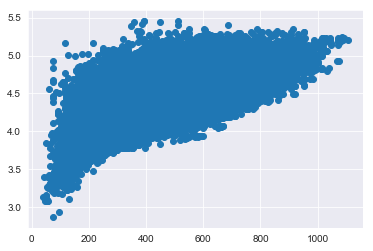

In [19]:
plt.scatter(df['TotalKg'], df['BodyweightKg'])
plt.show()

Here we can see that we obviously do not have constant variance, we can fix this with a simple log transformation.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


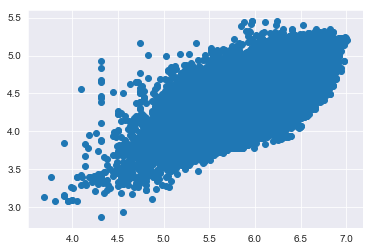

In [20]:
df['TotalKg'] = np.log(df['TotalKg'])

plt.scatter(df['TotalKg'], df['BodyweightKg'])
plt.show()

This looks much better!

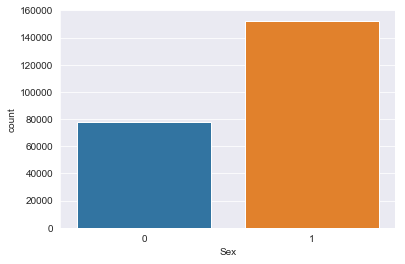

In [21]:
# Sex
sns.countplot(df['Sex'])
plt.show()

Here we have a decent amount of both labels for our category variable so it can fit the assumption.

In [23]:
X = df[['Wilks', 'Sex', 'TotalKg']]
y = df[['BodyweightKg']]

poly = PolynomialFeatures(degree=5)

X_train, X_test, y_train, y_test = train_test_split(poly.fit_transform(X), y, test_size=0.30, random_state=42)

model = linear_model.LinearRegression()
model.fit(X_train, y_train)

y_hat = model.predict(X_train)
trainError = np.mean((y_hat - y_train)**2)
print("Training error = %.5f" % trainError)

y_test_hat = model.predict(X_test)
testError = np.mean((y_test_hat - y_test)**2)
print("Test error = %.5f" % testError)

Training error = 0.00029
Test error = 0.00030


We can see the model performed extremely well. I chose a degree of 5 because I know the wilks coefficient formula is actually a 5 degree polynomial. The weights also differ for males and females which could explain why our error exactly zero. Another possiblilty is the rounding of the Wilks coefficient in the dataset.